Before beginning this notebook, ensure that you have data.csv in available in the working directory

In [48]:
#!python -m spacy download en

## Hyperparameter declaration

In [49]:
from argparse import Namespace

In [50]:
hype = Namespace(
    LR = 0.01,
    BATCH_SIZE = 128,
    NUM_EPOCHS = 100,
    CLIP = 1,
    DEVICE = None,
    save_checkpoint =True,
    load_checkpoint = False
)

In [51]:
checkpoint = Namespace(
    epoch_num = 0,
    model_params = None,
    optim_params = None,
    scheduler_params = None,
    losses = [],
)

In [52]:
#example usage
hype.BATCH_SIZE

128

In [53]:
#to dict
vars(hype)

{'BATCH_SIZE': 128,
 'CLIP': 1,
 'DEVICE': None,
 'LR': 0.01,
 'NUM_EPOCHS': 100,
 'load_checkpoint': False,
 'save_checkpoint': True}

## Data Processing

### Loading the data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [55]:
data = pd.read_csv('data.csv', header=None)
data.columns = ['english', 'marathi']
data.tail()

,english,marathi
40746,Just saying you don't like fish because of the...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...
40747,The Japanese Parliament today officially elect...,आज जपानी संसदेने अधिकृतरित्या र्‍यौतारौ हाशिमो...
40748,Tom tried to sell his old VCR instead of throw...,टॉमने त्याचा जुना व्ही.सी.आर फेकून टाकण्याऐवजी...
40749,You can't view Flash content on an iPad. Howev...,आयपॅडवर फ्लॅश आशय बघता येत नाही. पण तुम्ही त्य...
40750,"In 1969, Roger Miller recorded a song called ""...","१९६९मध्ये रॉजर मिलरने ""यू डोन्ट वॉन्ट माय लव्ह..."


### Building tokenizers

In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence

import re
import string

print(tf.__version__)

2.4.0


In [57]:
def sep_punk(text):
  for punk in string.punctuation:
    text = text.replace(punk," "+punk+" ")
  return text

def add_init_token(sent_list):
  new_sent_list = []
  for sent in sent_list:
    sent = sep_punk(sent)
    sent = '<sos> ' + sent + ' <eos>'
    new_sent_list.append(sent)

  return new_sent_list    

In [58]:
mar_list = list(data['marathi'])
eng_list = list(data['english'])

mar_list = add_init_token(mar_list)
eng_list = add_init_token(eng_list)

In [59]:
print(mar_list[100])
print(eng_list[100])

<sos> मी आहे !  <eos>
<sos> It ' s me !  <eos>


In [60]:
def tokenize(sent_list):
  tokenizer = text.Tokenizer(filters='')
  tokenizer.fit_on_texts(sent_list)

  tensor_list = tokenizer.texts_to_sequences(sent_list)
  tensor_list = sequence.pad_sequences(tensor_list, padding='post')
  
  return {'Tensors': tensor_list, 'Tokenizer': tokenizer} 

In [61]:
marathi = tokenize(sent_list=mar_list)
english = tokenize(sent_list=eng_list)

In [62]:
#print(type(english['Tokenizer']))

In [63]:
mar_tokenizer = marathi['Tokenizer']
eng_tokenizer = english['Tokenizer']

print(f'The length of marathi vocab: {len(mar_tokenizer.word_index)}')
print(f'The length of english vocab: {len(eng_tokenizer.word_index)}')

The length of marathi vocab: 13841
The length of english vocab: 5715


In [64]:
mar_tensors = marathi['Tensors']
eng_tensors = english['Tensors']

print(f'Max length of sequence: {len(mar_tensors[0])}')
print(f'Max length of sequence: {len(eng_tensors[0])}')


Max length of sequence: 44
Max length of sequence: 50


In [65]:
print(mar_tensors[0])
print(eng_tensors[0])

[  1 706   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
[ 1 48  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


### Implimenting TF Dataset

In [66]:
from tensorflow.data import Dataset

In [67]:
BUFFER_SIZE = len(mar_tensors)
BATCH_SIZE = 64

dataset = Dataset.from_tensor_slices((mar_tensors, eng_tensors)).shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [68]:
ex_mar_batch, ex_eng_batch = next(iter(dataset))
print(ex_mar_batch.shape)
print(ex_eng_batch.shape)

(64, 44)
(64, 50)


## Modelling

In [69]:
from tensorflow import nn
from tensorflow.keras import layers, Model

### Encoder

In [82]:
#Positional Encoding
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [83]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


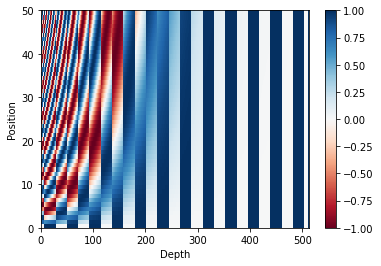

In [86]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [150]:
#Masks
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [151]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [144]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [145]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [90]:
#Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [91]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [92]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [93]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [94]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [95]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [96]:
# Multi HEad Attention
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [97]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [99]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [100]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [101]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [102]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [103]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [104]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [106]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [107]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [108]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [109]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [110]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [111]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [115]:
#Hyperparameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(mar_tokenizer.word_index) + 1
target_vocab_size = len(eng_tokenizer.word_index)+1 
dropout_rate = 0.1

In [116]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [117]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

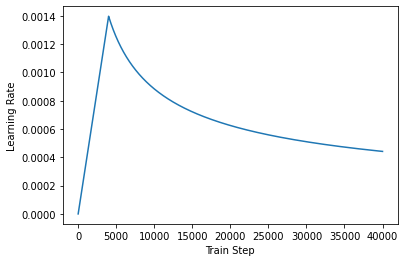

In [118]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [119]:
#LOss metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [120]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [121]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [70]:
'''class Encoder(Model):

  
  def __init__(self, vocab_size, embedding_size, enc_units, batch_size):
    
    super(Encoder, self).__init__()

    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding = layers.Embedding(vocab_size, embedding_size)
    self.gru = layers.GRU(enc_units, return_sequences= True, return_state= True, recurrent_initializer='glorot_uniform')


  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output,state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))'''

"class Encoder(Model):\n\n  \n  def __init__(self, vocab_size, embedding_size, enc_units, batch_size):\n    \n    super(Encoder, self).__init__()\n\n    self.batch_size = batch_size\n    self.enc_units = enc_units\n    self.embedding = layers.Embedding(vocab_size, embedding_size)\n    self.gru = layers.GRU(enc_units, return_sequences= True, return_state= True, recurrent_initializer='glorot_uniform')\n\n\n  def call(self, x, hidden):\n    x = self.embedding(x)\n    output, state = self.gru(x, initial_state=hidden)\n    return output,state\n\n  def initialize_hidden_state(self):\n    return tf.zeros((self.batch_size, self.enc_units))"

In [71]:
'''mar_vocab_size = len(mar_tokenizer.word_index) + 1
EMBEDDING_SIZE = 256
GRU_UNITS = 1024

encoder = Encoder(mar_vocab_size, EMBEDDING_SIZE, GRU_UNITS, BATCH_SIZE)'''

'mar_vocab_size = len(mar_tokenizer.word_index) + 1\nEMBEDDING_SIZE = 256\nGRU_UNITS = 1024\n\nencoder = Encoder(mar_vocab_size, EMBEDDING_SIZE, GRU_UNITS, BATCH_SIZE)'

In [73]:
#Example input
'''
ex_hidden = encoder.initialize_hidden_state()
sample_out, sample_hidden = encoder(ex_mar_batch, ex_hidden)

print(sample_out.shape)
print(sample_hidden.shape)'''

'\nex_hidden = encoder.initialize_hidden_state()\nsample_out, sample_hidden = encoder(ex_mar_batch, ex_hidden)\n\nprint(sample_out.shape)\nprint(sample_hidden.shape)'

### Attention

In [76]:
'''class Attention(layers.Layer):
 
  def __init__(self, units):

    super(Attention, self).__init__()
    self.W1 = layers.Dense(units)
    self.W2 = layers.Dense(units)
    self.V = layers.Dense(1)

  def call(self, q, val):
    #make q i.e. the hidden value into the same shape
    q_with_time_axis = tf.expand_dims(q, 1)

    score = self.V( nn.tanh( self.W1(q_with_time_axis) + self.W2(val) ) )

    attention_w = nn.softmax(score, axis=1)

    context_vec = attention_w * val
    context_vec = tf.reduce_sum(context_vec, axis=1)

    return context_vec, attention_w'''

'class Attention(layers.Layer):\n \n  def __init__(self, units):\n\n    super(Attention, self).__init__()\n    self.W1 = layers.Dense(units)\n    self.W2 = layers.Dense(units)\n    self.V = layers.Dense(1)\n\n  def call(self, q, val):\n    #make q i.e. the hidden value into the same shape\n    q_with_time_axis = tf.expand_dims(q, 1)\n\n    score = self.V( nn.tanh( self.W1(q_with_time_axis) + self.W2(val) ) )\n\n    attention_w = nn.softmax(score, axis=1)\n\n    context_vec = attention_w * val\n    context_vec = tf.reduce_sum(context_vec, axis=1)\n\n    return context_vec, attention_w'

In [74]:
#attention = Attention(10)

In [75]:
#example code
#attn_res ,  attn_w = attention(sample_hidden, sample_out)
##print(attn_res.shape)
#print(attn_w.shape)

### Decoder

In [ ]:
'''class Decoder(Model):

  def __init__(self, vocab_size, embedding_size, dec_units, batch_size):
    super(Decoder,self).__init__()

    self.batch_size = batch_size
    self.dec_units = dec_units
    
    self.embedding = layers.Embedding(vocab_size, embedding_size)
    self.gru = layers.GRU(dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    self.fc = layers.Dense(vocab_size)

    self.attention = Attention(dec_units)

  def call(self, x, hidden, enc_out):
    context_vec, attention_w = self.attention(hidden, enc_out)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)

    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_w

In [ ]:
'''eng_vocab_size = len(eng_tokenizer.word_index) + 1

decoder = Decoder(eng_vocab_size, EMBEDDING_SIZE, GRU_UNITS, BATCH_SIZE)

In [ ]:
#example code
'''
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),sample_hidden, sample_out)

print (sample_decoder_output.shape)

In [ ]:
#Implementing Transformer

## Training

### Optimizers and Loss Functions

In [122]:
from tensorflow.keras import optimizers as optim
from tensorflow.keras import losses

In [123]:
optimizer = optim.Adam()
criteria = losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = criteria(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss = loss*mask

  return tf.reduce_mean(loss)

In [ ]:
#Transformer

In [158]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [159]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

### Checkpoint

In [129]:
checkpoint_path = './tf_checkpoint'
checkpoint = tf.train.Checkpoint(optimizer = optimizer,
                                 transformer=transformer,
                                 )

### Training Loop

In [130]:
import time

In [160]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [161]:
EPOCHS = 20

In [172]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [181]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
   # tf.cast( inp, tf.int64)
    #tf.cast( tar, tf.int64)
    train_step(tf.cast( inp, tf.int64), tf.cast( tar, tf.int64))

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))


  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3977 Accuracy 0.4798
Epoch 1 Batch 50 Loss 0.4004 Accuracy 0.4646
Epoch 1 Batch 100 Loss 0.4049 Accuracy 0.4634
Epoch 1 Batch 150 Loss 0.4055 Accuracy 0.4622
Epoch 1 Batch 200 Loss 0.4061 Accuracy 0.4614
Epoch 1 Batch 250 Loss 0.4074 Accuracy 0.4612
Epoch 1 Batch 300 Loss 0.4084 Accuracy 0.4604
Epoch 1 Batch 350 Loss 0.4081 Accuracy 0.4604
Epoch 1 Batch 400 Loss 0.4088 Accuracy 0.4602
Epoch 1 Batch 450 Loss 0.4088 Accuracy 0.4599
Epoch 1 Batch 500 Loss 0.4090 Accuracy 0.4603
Epoch 1 Batch 550 Loss 0.4093 Accuracy 0.4604
Epoch 1 Batch 600 Loss 0.4095 Accuracy 0.4605
Epoch 1 Loss 0.4093 Accuracy 0.4607
Time taken for 1 epoch: 49.13785910606384 secs

Epoch 2 Batch 0 Loss 0.3628 Accuracy 0.5030
Epoch 2 Batch 50 Loss 0.3900 Accuracy 0.4715
Epoch 2 Batch 100 Loss 0.3910 Accuracy 0.4707
Epoch 2 Batch 150 Loss 0.3921 Accuracy 0.4698
Epoch 2 Batch 200 Loss 0.3927 Accuracy 0.4696
Epoch 2 Batch 250 Loss 0.3944 Accuracy 0.4681
Epoch 2 Batch 300 Loss 0.3960 Accuracy 0.4673
Ep

In [135]:
'''EPOCHS = 10
steps_per_epoch = len(mar_tensors)//BATCH_SIZE


for epoch in range(EPOCHS):
  start = time.time()

  #enc_hidden = encoder.initialize_hidden_state()

  total_loss = 0

  for (batch, (src,trg)) in enumerate(dataset.take(steps_per_epoch)):
    train_step(src, trg)
    batch_loss = train_step(src, trg, enc_hidden)

    total_loss += batch_loss

    if batch%100 == 0:
      print(f'Epoch {epoch} Batch {batch} Loss{batch_loss.numpy():.4f}')

  
  if (epoch+1)%2 == 0:
    checkpoint.save(file_prefix=checkpoint_path)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

TypeError: ignored

In [ ]:
from matplotlib import ticker

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((eng_tensors.shape[1],mar_tensors.shape[1]))

  sentence = sep_punk(sentence)

  inputs = [mar_tokenizer.word_index[i] for i in sentence.split(' ') if i!='']
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=mar_tensors.shape[1],
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, GRU_UNITS))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([eng_tokenizer.word_index['<sos>']], 0)

  for t in range(eng_tensors.shape[1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += eng_tokenizer.index_word[predicted_id] + ' '

    if eng_tokenizer.index_word[predicted_id] == '<eos>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [ ]:
res, sentence , _ = evaluate(data['marathi'][20212])


print(sentence)
print(data['english'][20212])
print(res)

तिघांना अटक करण्यात आली . 
The three were arrested.
the three were arrested . <eos> 
